# Short demo of a CTC handwriting model for words and line-level handwriting recognition

Firstly, a lot of the basis for code and ideas for these models come from Harald Scheidl's [blogpost](https://towardsdatascience.com/build-a-handwritten-text-recognition-system-using-tensorflow-2326a3487cd5) and [github repository](https://github.com/githubharald/SimpleHTR) on building a handwritten text recognition system using tensorflow. The blogposts are a great place to start to cover a Conv-RNN-CTC network used for this task.

I have made a few changes, removing the constraint to keep small enough to train on CPU:
 - This has been re-written in pytorch over tensorflow
 - The [deslant algorithm](https://github.com/githubharald/DeslantImg) has been rewritten with a python implementation in openCV. It is better to run it on all training images and resave as a deslanted dataset rather than inside a transform pipeline (although it is useful to have it in the prediction transform pipeline).
 - I have increased the size of the convolution part using an initially pretrained Resnet34, with some modifications to the downsample steps. This has increased the number of features extracted during the convolution part of the network to 512 from 256.
 - The number of layers of the LSTM have been increased from 2 to 4, and the number of the hidden units has increased to 512. 
 - I have increased the fraction of examples used for validation from 5% to 20%.
 - I have added Levenshtein distance as an evaluation metric, mainly because character error rate is problematic for line level predictions due to alignment problems if one letter is missed.
 
The most crucial idea for the network is that of Connectionist Temporal Classification (CTC) loss, which allows an alignment free method to map an input sequence to an output. To get an idea of the CTC loss see [here](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c), and [here](https://distill.pub/2017/ctc/).

## Dataset format and dataloaders

To load the data and batch it up for training, I have used the pytorch Dataset and Dataloader classes to create custom versions for this task. The original dataset used to train the model is the IAM handwriting offline data, but with the weights and decode maps provided you can start to train on your own dataset. 

The custom Dataset class CTCData requires the data to be in a certain format to be able to load it properly. The images and a csv should be organised with the following folder structure:
- root dir:
    - words.csv
    - a01
        - a01-000u-00-00.png
        - a01-000u-00-01.png
    - r06
        - r06-143-02-07.png
        - r06-143-02-09.png
    - ...

Within the IAM dataset the different image folders refer to the form that the word or line was captured from, which is also information contained in the first element of the filename. The CSV should have the format of that below.

In [1]:
import pandas as pd
df = pd.read_csv('words/deslanted/words.csv')
df.head()

,file,ok,word
0,a01-000u-00-00.png,ok,A
1,a01-000u-00-01.png,ok,MOVE
2,a01-000u-00-02.png,ok,to
3,a01-000u-00-03.png,ok,stop
4,a01-000u-00-04.png,ok,Mr.


The CSV should have the format of the filename (with extension - e.g .png) in the first column (the column name doesn't matter), the first element of the filename should be the same as the folder `a01-000u-00-00.png` is in `root_dir\a01\`. The 'word' transcription column can be at any position, and with any column name, as position can be specified with the `word_col` attribute of the CTCData class. The 'ok' column represents the result of word segmentation for the IAM dataset, and is irrelevant for training.

To get the data ready for training the csv needs to passed to the CTCDataset class:

In [2]:
from dataset import CTCData
from dataloader import CTCDataLoader
from transforms import Rescale, Deslant, toRGB, ToTensor, Normalise
from torchvision.transforms import Compose
import torch

# use gpu if available
dev = "cuda" if torch.cuda.is_available() else "cpu"

# create the CTCDataset
dataset = CTCData(csv_file='word_line.csv',                                               # csv name
        root_dir='/home/jupyter/tutorials/my_projects/word_recognition/lines/deslanted',  # root directory of csv and images
                  transform=Compose([                                                     # compose sequence of transforms
                   # Deslant(),                                                           # Deslant whole dataset before.
                     Rescale(output_size=(64, 800),                                       # one key part is that the image
                            random_pad=True,                                              # is rotated 90 degrees (w, h)
                            border_pad=(4, 10), 
                            random_rotation=2,                                            # random angle rotation (+/-)
                            random_stretch=1.2),                                          # randomly stretch the line (up to)
                     toRGB(),                                                            # converted to RGB - imagenet 
                     ToTensor(rgb=True),                                                 # was 3 channel images
                      Normalise(mean=[0.485, 0.456, 0.406],                              # pretrained resnet
                                  std=[0.229, 0.224, 0.225])]))                          # must use imagenet stats!

# Create a dataloader
dl = CTCDataLoader(dataset,                                                              # pass the dataset
                   batch_size=(120,240),                                                 # train batchsize, val batchsize
                   validation_split=0.2,                                                 # size of validation split [0-1]
                   shuffle=True,                                                         # shuffle the dataset
                   seed=42,                                                              # random seed - for reproducibility
                   device=dev)                                                           # on CPU or GPU?

The CTCData object has two useful attributes: 
 - `dataset.max_len` contains the length of the longest word, as in the case above, or sentence if you pass a line level dataset.
 - `dataset.char_dict` has the characters from the dataset as keys and the corresponding index in the CTC matrix as the value. There is no key with the value `0` as this is reserved for the special blank character of the CTC matrix.

## Training from scratch

To train from 'scratch' we can initialise a new model. The model has two parts a ResNet34 as convolution step which extract features from the input image and LSTM which maps those sequence of features to a CTC matrix. As a ResNet has a large number of parameters, it is possible to use transfer learning and start with pretrained weights trained on imagenet dataset. The LSTM will have fresh weights.

In [ ]:
from model import CTCModel
model = CTCModel(chan_in=3,                                                             # 3 channel image - imagenet pretrained
                 time_step=96,                                                          # this is the max length possible                                                  
                 feature_size=512,                                                      # conv outputs 512, 32, 1
                 hidden_size=512,                        
                output_size=len(dataset.char_dict) + 1,                                 # output matrix has to have col for each letter
                 num_rnn_layers=4,                                                      # plus 1 for special blank character 
                 rnn_dropout=0)
model.load_pretrained_resnet()                                                          # load some pretrained weights
model.to(dev)                                                                           # put the model parameters on CPU/GPU

The Learner class is essentially an exercise in recreating some components of the [fastai](https://github.com/fastai/fastai) library, to get a fuller understanding of some of the features such as learning rate finder and one cycle policy. It mainly served as a learning exercise (no pun intended).

By using the fastai datablock API and applying the custom transforms, along with the CTC loss you could use fastai library natively, and it would probably make more sense. Additionally you would need to define a custom metric(s) - the Levenshtein edit distance is a good choice for evaluating. 

With the Learner class you can freeze the weights of the convolution part of the network and only train the new LSTM head.

/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


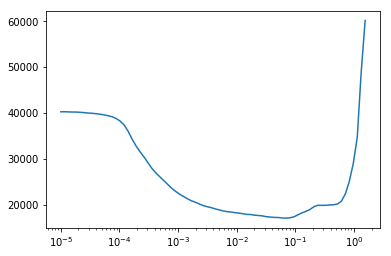

In [5]:
from learn import Learner
learn = Learner(model=model,                                                           
                dataloader=dl,                                                         
               decode_map={v:k for k,v in dataset.char_dict.items()})                  # inverse of char_dict
learn.freeze()                                                                         # freeze the conv weights
log, lr = learn.find_lr(start_lr=1e-5, end_lr=1e1, wd=0.1)                             # find a suitable learning rate
                                                                                       # wd = weight decay
# based on https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

The `learn.fit_one_cycle` method will fit the model using the [one cycle policy](https://arxiv.org/abs/1803.09820). The one cycle policy involves starting with a small learning rate and increasing to a larger rate linearly over a number of iterations, before decreasing back to the base rate again. The higher learning rates in the middle of the cycle have a regularising effect, preventing the model from getting stuck in areas of local minima, and then lower rates at the end allow slow descent in a good loss landscape.

In [5]:
# first run - frozen - just a demo - want to do more epochs if actual training
print('Training with ResNet parameters frozen')
learn.fit_one_cycle(epochs=1, max_lr=1e-3, base_lr=1e-4, wd=0.1)

# unfreeze all weights
print('Training with all parameters (CNN + LSTM) unfrozen')
learn.unfreeze()
learn.fit_one_cycle(epochs=1, max_lr=1e-3, base_lr=1e-4, wd=0.1)

epoch 1: train loss 6524.685546875 | valid loss 2698.087890625 | CER 0.9947349183694781 | WER 1.0
TRAIN LEVEN 1.639094113670385 | VAL LEVEN 1.6414696974971281
epoch 1: train loss 976.9447021484375 | valid loss 1763.383056640625 | CER 0.9980245065617711 | WER 1.0
TRAIN LEVEN 1.7046389287422286 | VAL LEVEN 1.707487729313886


During training current train loss and batch number are printed. After each epoch a number of metrics are printed:
- Train and Validation loss
- Character Error Rate (CER)
- Item Error Rate (IER)
- The sum of the Levenshtein edit distances divide by sum of the target lengths, for both the training and validation set

## Loading in saved model weights

There are two saved model in the `weights` folder of this repository. `weights/line` has a the weights and decode map for a line level handwriting recognition and `weights/words`

The line level has an 7.1% edit rate between predicted and targets, and overall item level accuracy of 36% (complete lines with no errors) using a best path decoding of the CTC matrix. The line level model expects image input with as size of 64x800 (width x height), and it can output 79 characters (A-Z,a-z,0-9, plus punctuation including space).

The word level model has a similar 7.1% edit rate between predicted and actual and as there is less opportunity for alignment error, a very similar character error rate. Overall the item error rate is 14%. 
The word level model expects image input with as size of 64x256 (width x height), and it can output 78 characters (A-Z,a-z,0-9, plus punctuation).

These models could be improved with different decoding of the CTC matrix such as only allowing a dictionary of words, or beam search, but these serve as starting point for training with your own data.

### How to load the line level

In [6]:
from dataset import CTCData
from dataloader import CTCDataLoader
from transforms import Rescale, Deslant, toRGB, ToTensor, Normalise
from torchvision.transforms import Compose
import torch

# use gpu if available
dev = "cuda" if torch.cuda.is_available() else "cpu"

# create the CTCDataset - if you want to train
dataset = CTCData(csv_file='word_line.csv',                                               # csv name
        root_dir='/home/jupyter/tutorials/my_projects/word_recognition/lines/deslanted',  # root directory of csv and images
                  transform=Compose([                                                     # compose sequence of transforms
                   # Deslant(),                                                           # Deslant whole dataset before.
                     Rescale(output_size=(64, 800),                                       # one key part is that the image
                            random_pad=True,                                              # is rotated 90 degrees (w, h)
                            border_pad=(4, 10), 
                            random_rotation=2,                                            # random angle rotation (+/-)
                            random_stretch=1.2),                                          # randomly stretch the line (up to)
                     toRGB(),                                                            # converted to RGB - imagenet 
                     ToTensor(rgb=True),                                                 # was 3 channel images
                      Normalise(mean=[0.485, 0.456, 0.406],                              # pretrained resnet
                                  std=[0.229, 0.224, 0.225])]))                          # must use imagenet stats!

# Create a dataloader - if you want to train
dl = CTCDataLoader(dataset,                                                              # pass the dataset
                   batch_size=(120,240),                                                 # train batchsize, val batchsize
                   validation_split=0.2,                                                 # size of validation split [0-1]
                   shuffle=True,                                                         # shuffle the dataset
                   seed=42,                                                              # random seed - for reproducibility
                   device=dev)                                                           # on CPU or GPU?


from model import CTCModel
model = CTCModel(chan_in=3,                                                             # 3 channel image - imagenet pretrained
                 time_step=96,                                                          # CTC matrix for lines is 96x80                                                  
                 feature_size=512,                                                      # conv outputs 512, 32, 1
                 hidden_size=512,                        
                output_size=len(dataset.char_dict) + 1, # IAM Lines dataset = 80        # CTC matrix for lines is 96x80
                 num_rnn_layers=4,                                                      # plus 1 for special blank character 
                 rnn_dropout=0)
model.to(dev)

from learn import Learner
learn = Learner(model=model,                                                           
                dataloader=dl, # if you don't wish to train this can be lambda: (None, None)/Dataset and dataloader skipped.
                decode_map=None)   

learn.load(f='weights/line/line.pth',                                                 # file path of weights
           inv_f='weights/line/line_decode.pkl',                                       # path to the decode map
           load_decode=True,                                                           # do we want to replace current decode
           keep_LSTM=True,                                                             # if char_dict is same as IAM can keep
          freeze_conv=False)                                                            # freeze the convolution part

# do the actual freezing if chosen above
# learn.freeze()


# # if you have a dataset that has characters different from those in IAM lines you will want to drop the LSTM parameters
# You should also set these in the output_size of the model, either defined manually or from dataset.char_dict
# learn.load(f='weights/line/lines.pth',                                                 
#            inv_f='weights/line/line_decode.pkl',                                       
#            load_decode=True,                                                           
#            keep_LSTM=False,                                                             
#           freeze_conv=True)
# learn.freeze()
# AND THEN FIT FOR A BIT 

### How to load the word level
To load the word level model is very similar to above but with the following changes:

In [ ]:
# ...
dataset = CTCData(csv_file='words.csv', 
                  root_dir='/home/jupyter/tutorials/my_projects/word_recognition/words',
                  transform=Compose([
                     Rescale(output_size=(64, 256),
                            random_pad=True,
                            border_pad=(10, 40), 
                            random_rotation=3,
                            random_stretch=1.4),
                     toRGB(), 
                     ToTensor(rgb=True),
                      Normalise(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]))
# ...

model = CTCModel(chan_in=3, time_step=32, feature_size=512, hidden_size=512,
                output_size=len(dataset.char_dict) + 1, num_rnn_layers=4, rnn_dropout=0)

# ...
learn.load(f='weights/word/word.pth',                                                 
           inv_f='weights/word/word_decode.pkl',                                      
           load_decode=True,                                                          
           keep_LSTM=True,
           freeze_conv=True) 

## Predictions
The Learner class has a function to show predictions on the validation set and also to make single image predictions from disk.

single batch prediction of valid dataset


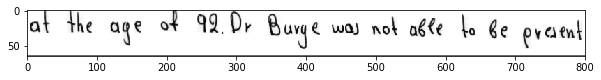

actual: at the age of 92 . Dr. Burge was not able to be present
pred:   at the age of 92. Dr Burge was not able to be present


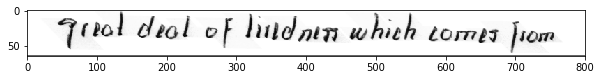

actual: great deal of tiredness which comes from
pred:   great deal of tiredness which comes from


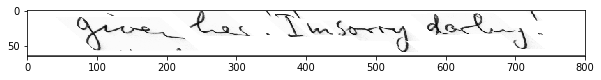

actual: given her . ' I 'm sorry , darling . '
pred:   give her ' Imsorry darling !'


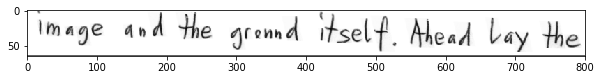

actual: image and the ground itself . Ahead lay the
pred:   image and the greund itself . Ahead lay the


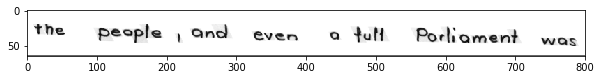

actual: the people , and even a full Parliament was
pred:   the people , and even a full Parliament was


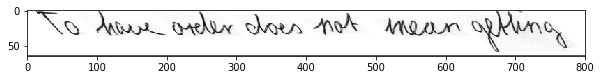

actual: To have order does not mean getting
pred:   To have order does not mean getting


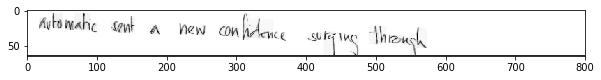

actual: automatic sent a new confidence surging through
pred:   astomatic sent a new confidace surging through


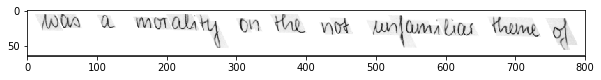

actual: was a morality on the not unfamiliar theme of
pred:   was a morality on the not unfamiliar theme of


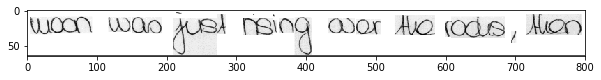

actual: moon was just rising over the rocks , then
pred:   moon was just rising over the rocks , then


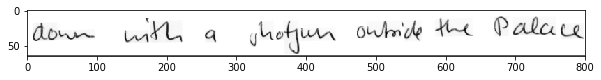

actual: down with a shotgun outside the Palace
pred:   down with a shotgen outside the Palace


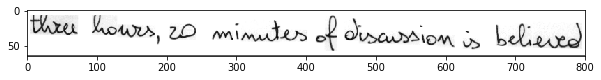

actual: three hours , 20 minutes of discussion is believed
pred:   three howes , 20 minutes of discussion is believed


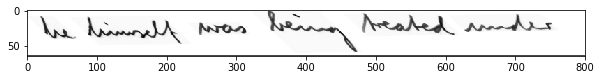

actual: he himself was being treated under
pred:   he himself was being treated under


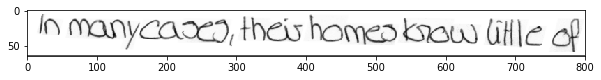

actual: In many cases , their homes know little of
pred:   In many cases , their homes know little of


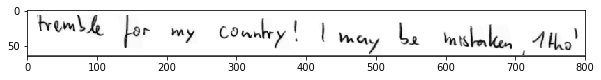

actual: tremble for my country ! I may be mistaken , 1tho'
pred:   tremble for my country ! I may be mistaken , 1tho'


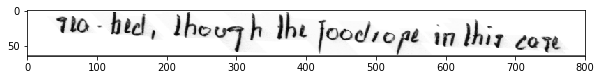

actual: sea-bed , though the footrope in this case
pred:   sea-bed , though the footrope in this case


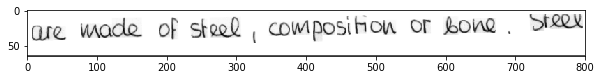

actual: are made of steel , composition or bone . Steel
pred:   are made of steel , composition or bone . Steel


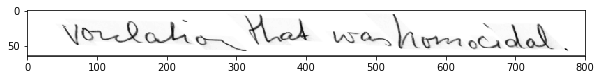

actual: vulsion that was homicidal .
pred:   voulsion that was homocidal .


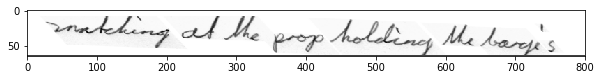

actual: snatching at the prop holding the barge's
pred:   snatching at the prop holding the barge's


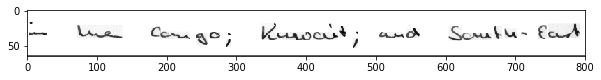

actual: in the Congo ; Kuwait ; and South-East
pred:   in the Congo ; Kuwait ; and South-East


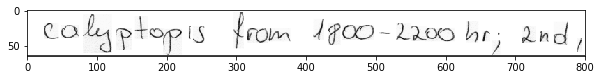

actual: calyptopis from 1800-2200 hr ; 2nd ,
pred:   calyptopis from 1800-2200 hr ; and ,


In [7]:
learn.batch_predict(show_img=True, up_to=20)

To do a single image prediction from disk you need to pass the transforms in the order you wish to do them. At prediction time it is unlikely that you will want to do data augmentation so random pad, rotation and stretch can be set to False, 0 and 1.0 respectively.

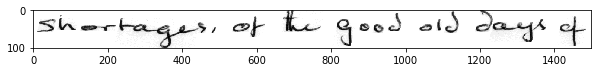

shortages , of the good old days of


In [8]:
trans  = Compose([                                                     # compose sequence of transforms
                       Rescale(output_size=(64, 800),                                       # one key part is that the image
                            random_pad=False,                                              # is rotated 90 degrees (w, h)
                            border_pad=(4, 10), 
                            random_rotation=0,                                            # random angle rotation (+/-)
                            random_stretch=1.0),                                          # randomly stretch the line (up to)
                     toRGB(),                                                            # converted to RGB - imagenet 
                     ToTensor(rgb=True),                                                 # was 3 channel images
                      Normalise(mean=[0.485, 0.456, 0.406],                              # pretrained resnet
                                  std=[0.229, 0.224, 0.225])])
pred = learn.predict(img_path='lines/deslanted/b04/b04-020/b04-020-06.png', transforms=trans, show_img=True, dev=dev)

# Further work
It is unlikely that the model will work out the box for other applications, as the IAM dataset has some oddities, and may not reflect data that you have collect. 

But as the model comes pretrained it may make a start, and with a little further training it will likely improve, whilst need considerably less examples than training from scratch.